# Fine-Tuning ChemBERTa for Regression

Different learning rates, number of epochs, and batch sizes were explored

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import torch.nn as nn

In [2]:
# Load the dataset
df = pd.read_csv("data/qm9_recommended_data.csv")
print(f'Number of examples is: {len(df)}')
df.head()

Number of examples is: 133055


,PBE_TZP,B3LYP(VWN5)_TZP,GFNXTB,M06-2X_TZP,smiles,chemformula,index
0,-18.261372,-19.140565,-21.979934,-19.987828,[H]C([H])([H])[H],CH4,1
1,-12.975380,-12.896428,-17.405808,-12.694483,[H]N([H])[H],H3N,2
2,-10.370616,-11.226953,-14.033122,-12.538535,[H]O[H],H2O,3
3,-18.070231,-19.266542,-22.665365,-21.246587,[H]C#C[H],C2H2,4
4,-14.127323,-14.386552,-19.345571,-15.292001,[H]C#N,CHN,5


In [3]:
# Load the pre-trained model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MLM"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Determine the maximum sequence length
max_length = tokenizer.model_max_length
print(max_length)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

def canonical_smiles(smiles):
    canonicalized_smiles = []

    for smi in smiles:
        try:
            # Create a molecule and sanitize it
            mol = Chem.MolFromSmiles(smi, sanitize=False)
            if mol is None:
                raise ValueError(f"Invalid SMILES: {smi}")

            # Sanitize the molecule
            Chem.SanitizeMol(mol)

            # Convert to canonical SMILES
            canonicalized_smiles.append(Chem.MolToSmiles(mol))
        except Exception as e:
            print(f"Error processing SMILES '{smi}': {e}")
            canonicalized_smiles.append(None)  # Append None for invalid SMILES

    return canonicalized_smiles

In [5]:
# Runf the canonicalization
canonicalized_smiles = canonical_smiles(df['smiles'].tolist())
print(len(df))
print(len(canonicalized_smiles))

133055
133055


In [6]:
# Add CANONICAL_SMILES
df['CANONICAL_SMILES'] = canonicalized_smiles    

In [7]:
# Tokenization function
def tokenize(string):
    """
    Tokenize and encode a string using the provided tokenizer.
    
    Parameters:
        string (str): Input string to be tokenized.
    
    Returns:
        Tuple of input_ids and attention_mask.
    """
    encodings = tokenizer.encode_plus(
        string,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_attention_mask=True
    )
    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    return input_ids, attention_mask

# Tokenize the 'CANONICAL_SMILES' column and create new columns 'input_ids' and 'attention_mask'
tqdm.pandas()
df[["input_ids", "attention_mask"]] = df["smiles"].progress_apply(lambda x: tokenize(x)).apply(pd.Series)

  0%|          | 0/133055 [00:00<?, ?it/s]

100%|██████████| 133055/133055 [00:12<00:00, 10931.33it/s]


In [8]:
df.head()

,PBE_TZP,B3LYP(VWN5)_TZP,GFNXTB,M06-2X_TZP,smiles,chemformula,index,CANONICAL_SMILES,input_ids,attention_mask
0,-18.261372,-19.140565,-21.979934,-19.987828,[H]C([H])([H])[H],CH4,1,[H]C([H])([H])[H],"[12, 16, 17, 18, 17, 18, 13, 0, 0, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,-12.975380,-12.896428,-17.405808,-12.694483,[H]N([H])[H],H3N,2,[H]N([H])[H],"[12, 23, 17, 18, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,-10.370616,-11.226953,-14.033122,-12.538535,[H]O[H],H2O,3,[H]O[H],"[12, 19, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,-18.070231,-19.266542,-22.665365,-21.246587,[H]C#C[H],C2H2,4,[H]C#C[H],"[12, 16, 38, 16, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,-14.127323,-14.386552,-19.345571,-15.292001,[H]C#N,CHN,5,[H]C#N,"[12, 16, 38, 23, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=21)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=21)
print(f"There are {len(train_df)} molecules in Train df.")
print(f"There are {len(val_df)} molecules in Val df.")
print(f"There are {len(test_df)} molecules in Test df.")

There are 106444 molecules in Train df.
There are 13305 molecules in Val df.
There are 13306 molecules in Test df.


In [10]:
# Function to convert data to PyTorch tensors
def get_tensor_data(data):
    """
    Convert data to PyTorch tensors.
    
    Parameters:
        data (DataFrame): Input data containing 'input_ids', 'attention_mask', and 'pIC50' columns.
    
    Returns:
        TensorDataset containing input_ids, attention_mask, and labels tensors.
    """
    input_ids_tensor = torch.tensor(data["input_ids"].tolist(), dtype=torch.int32)
    attention_mask_tensor = torch.tensor(data["attention_mask"].tolist(), dtype=torch.int32)
    labels_tensor = torch.tensor(data["PBE_TZP"].tolist(), dtype=torch.float32)
    return TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)

# Create datasets and data loaders
train_dataset = get_tensor_data(train_df)
val_dataset = get_tensor_data(val_df)
test_dataset = get_tensor_data(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
# Loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
torch.manual_seed(12345)
for epoch in tqdm(range(epochs)):
    # Training loop
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output_dict = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        predictions = output_dict.logits.squeeze(dim=1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            output_dict = model(input_ids, attention_mask=attention_mask, labels=labels)
            predictions = output_dict.logits.squeeze(dim=1)
            loss = criterion(predictions, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"epoch {epoch + 1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")


 10%|█         | 1/10 [10:28<1:34:19, 628.80s/it]

epoch 1: Train Loss 260.4838, Val Loss 120.4763


 20%|██        | 2/10 [21:02<1:24:11, 631.43s/it]

epoch 2: Train Loss 125.6776, Val Loss 120.8976


 30%|███       | 3/10 [31:34<1:13:44, 632.07s/it]

epoch 3: Train Loss 138.2272, Val Loss 120.4558


 40%|████      | 4/10 [42:07<1:03:14, 632.34s/it]

epoch 4: Train Loss 125.7004, Val Loss 121.6456


 50%|█████     | 5/10 [52:40<52:42, 632.47s/it]  

epoch 5: Train Loss 125.6113, Val Loss 120.8397


 60%|██████    | 6/10 [1:03:13<42:10, 632.68s/it]

epoch 6: Train Loss 125.4516, Val Loss 120.7007


 70%|███████   | 7/10 [1:13:46<31:38, 632.76s/it]

epoch 7: Train Loss 125.8090, Val Loss 120.4837


 80%|████████  | 8/10 [1:24:19<21:05, 632.75s/it]

epoch 8: Train Loss 125.9951, Val Loss 120.4260


 90%|█████████ | 9/10 [1:34:52<10:32, 632.80s/it]

epoch 9: Train Loss 125.9131, Val Loss 122.6513


100%|██████████| 10/10 [1:45:24<00:00, 632.45s/it]

epoch 10: Train Loss 125.6061, Val Loss 120.5266


In [12]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
         

In [13]:
# Testing loop
total_test_loss = 0
test_labels = []
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output_dict = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = output_dict.logits.squeeze(dim=1)
        loss = criterion(predictions, labels)
        total_test_loss += loss.item()
        test_labels.extend(labels.tolist())
        test_predictions.extend(predictions.tolist())
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss {avg_test_loss:.4f}")

Test Loss 119.8831


Text(0, 0.5, 'Actual')

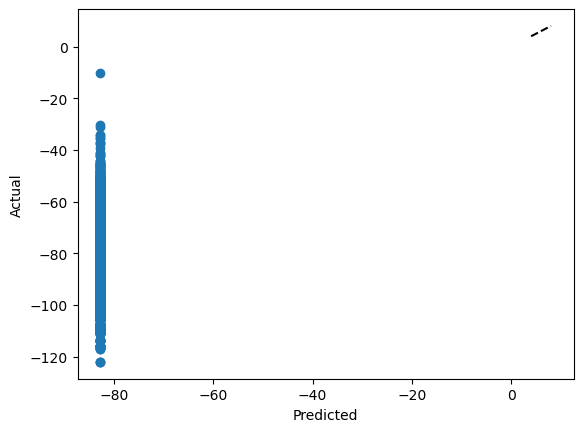

In [14]:
import matplotlib.pyplot as plt
plt.scatter(test_predictions, test_labels)
plt.plot([4, 8], [4, 8], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Save the model

In [15]:
# Define save directory
save_directory = "./chemberta_finetuned_model"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")

Model saved to ./chemberta_finetuned_model


## Loading full model

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [23]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
         

## Predict on new smiles

In [24]:
# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
         

In [29]:
# 2. Tokenize a new SMILES string
def tokenize_smiles(smiles, tokenizer, max_length=512):
    encoding = tokenizer(
        smiles,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"  # Return PyTorch tensors
    )
    return encoding["input_ids"], encoding["attention_mask"]

new_smiles = "[H]O[H]"  # <-- Third row in df, true value is -10.370616	
input_ids, attention_mask = tokenize_smiles(new_smiles, tokenizer)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

In [30]:
# 3. Predict
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    prediction = outputs.logits.squeeze().item()  # For regression output

print(f"Predicted value for SMILES '{new_smiles}': {prediction:.4f}")

Predicted value for SMILES '[H]O[H]': -82.7963


# Again but with early stopping + learning rate scheduler + gradient clipper (for stability) + extra logging

In [ ]:
# # Loss criterion and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Training parameters
# epochs = 10
# best_val_loss = float('inf')
# patience = 3
# patience_counter = 0

# torch.manual_seed(12345)

# for epoch in tqdm(range(epochs)):
#     # Training loop
#     model.train()
#     total_train_loss = 0
#     for batch in train_loader:
#         optimizer.zero_grad(set_to_none=True)
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
#         output_dict = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         predictions = output_dict.logits.squeeze(dim=1)
#         loss = criterion(predictions, labels)
        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         total_train_loss += loss.item()
    
#     avg_train_loss = total_train_loss / len(train_loader)

#     # Validation loop
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
#             output_dict = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             predictions = output_dict.logits.squeeze(dim=1)
#             loss = criterion(predictions, labels)
#             total_val_loss += loss.item()
    
#     avg_val_loss = total_val_loss / len(val_loader)
#     print(f"Epoch {epoch + 1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")
    
#     # Learning rate scheduling
#     scheduler.step(avg_val_loss)
    
#     # Early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_chemberta_model.pth')
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print(f"Early stopping at epoch {epoch + 1}")
#             break

# print("Training completed!")